In [1]:
from keras.datasets import fashion_mnist

Using TensorFlow backend.


In [2]:
(X_train_original, y_train_original),(X_test_original, y_test_original) = fashion_mnist.load_data()

In [3]:
import numpy as np
from keras.utils import to_categorical
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
print('Training data shape : ', X_train_original.shape, y_train_original.shape)
print('Training data shape : ', X_test_original.shape, y_test_original.shape)

Training data shape :  (60000, 28, 28) (60000,)
Training data shape :  (10000, 28, 28) (10000,)


In [5]:
classes = np.unique(y_train_original)
n_classes = len(classes)
print('Number of outputs: ', n_classes)
print('Output classes: ', classes)

Number of outputs:  10
Output classes:  [0 1 2 3 4 5 6 7 8 9]


<Figure size 360x360 with 0 Axes>

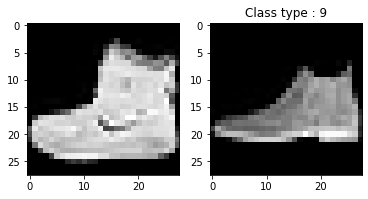

In [6]:
#Let us take a look at the images
plt.figure(figsize = [5,5])
#Display the first figure

figs, axes = plt.subplots(ncols =2, nrows=1)
axes[0].imshow(X_train_original[0], cmap='gray')
plt.title("Class type : {}".format(y_train_original[0]))
axes[1].imshow(X_test_original[0], cmap='gray')
plt.title("Class type : {}".format(y_test_original[0]))
plt.show()


Text(0.5, 1.0, 'Class: 9')

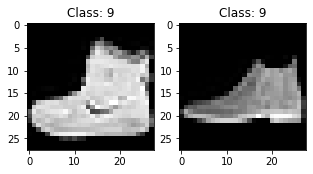

In [7]:
plt.figure(figsize=[5,5])

# Display the first image in training data
plt.subplot(121)
plt.imshow(X_train_original[0], cmap='gray')
plt.title("Class: {}".format(y_train_original[0]))

# Display the first image in testing data
plt.subplot(122)
plt.imshow(X_test_original[0], cmap='gray')
plt.title("Class: {}".format(y_test_original[0]))

In [8]:
#How many boots are in the training dataset
boots = y_train_original == 9
print(boots.sum())


6000


In [10]:
print(type(X_test_original))
print(X_train_original.shape)

<class 'numpy.ndarray'>
(60000, 28, 28)


In [9]:
#It is time to reshape images into matrix of 28x28x1
X_train_reshape = X_train_original.reshape(-1,28,28,1)
X_test_reshape = X_test_original.reshape(-1,28,28,1)
print("New X_train shape: ", X_train_reshape.shape)
print("New X_test shape: " , X_test_reshape.shape)

New X_train shape:  (60000, 28, 28, 1)
New X_test shape:  (10000, 28, 28, 1)


In [10]:
#As NN need to work with float numbers we need to convert the uint type format of the dataset into float32,
#as well as to scale pixel ranges from 0-1 for a good learning
X_train_scaled = X_train_reshape.astype('float32')
X_test_scaled = X_test_reshape.astype('float32')
X_train_scaled = X_train_scaled / 255
X_test_scaled = X_test_scaled / 255

In [11]:
print(np.max(X_train_scaled[0]))

1.0


In [12]:
#Time to make the one hot encoding for categorical classification
y_train_ohe = to_categorical(y_train_original)
print(y_train_ohe[0])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


In [13]:
y_test_ohe = to_categorical(y_test_original)
print(y_test_ohe[0])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


In [14]:
print(y_test_ohe.shape)

(10000, 10)


In [15]:
#Here comes the interesting part!!!!
#But first we should split data into train and validation set in order to make a pretty good learning and avoid overfitting
#Let us import the appropiate library to do this
from sklearn.model_selection import train_test_split

In [16]:
X_train, X_val, y_train, y_val = train_test_split(X_train_scaled, y_train_ohe, test_size =0.2, random_state = 123)

In [17]:
print(X_train.shape, X_val.shape,y_train.shape, y_val.shape)

(48000, 28, 28, 1) (12000, 28, 28, 1) (48000, 10) (12000, 10)


## Time to define the structure of the CNN

This is an 'easy' network, it will consist of three convolutional layers, 
 1. First layer will be 3x3 filter with 32 convolutional units
 2. Second layer will be 3x3 for 64 conv units
 3. Third layer a 3x3 with 128 units.

As well as three MaxPooling layers of 2x2 after each convolutinal layer



In [18]:
#Importing the necessary modules
import keras
from keras.models import Sequential, Input, Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, MaxPool2D
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU

In [19]:
batch_size = 64
epochs = 20
num_classes = 10

In [20]:
import keras.backend as K

K.clear_session()

### CNN Architecture

In [21]:
model = Sequential()
model.add(Conv2D(32,kernel_size=3, activation='relu', input_shape = (28,28,1), padding='same'))
model.add(MaxPool2D(2))
model.add(Conv2D(64, kernel_size=3, activation='relu', padding = 'same'))
model.add(MaxPool2D(2))
model.add(Conv2D(128, kernel_size = 3, activation='relu', padding='same'))
model.add(MaxPool2D(2))
model.add(Flatten())
model.add(Dense(128, activation = 'relu'))
model.add(Dense(num_classes, activation = 'softmax'))


In [22]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics = ['accuracy'])

In [23]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 128)         73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 3, 3, 128)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1152)             

In [24]:
from keras.callbacks import EarlyStopping

# Define a callback to monitor val_acc
monitor_val_acc = EarlyStopping(monitor='val_accuracy', 
                       patience=5)

# Train your model using the early stopping callback
#model.fit(X_train, y_train, epochs=1000, validation_data= (X_test,y_test),callbacks=[monitor_val_acc])

In [25]:
train_history = model.fit(X_train,y_train, batch_size= batch_size, 
                          epochs = 20,validation_data=(X_val,y_val), callbacks=[monitor_val_acc])

Train on 48000 samples, validate on 12000 samples
Epoch 1/20
48000/48000 [==============================] - 8s 169us/step - loss: 0.5065 - accuracy: 0.8173 - val_loss: 0.3464 - val_accuracy: 0.8736
Epoch 2/20
48000/48000 [==============================] - 5s 114us/step - loss: 0.3140 - accuracy: 0.8857 - val_loss: 0.2975 - val_accuracy: 0.8939
Epoch 3/20
48000/48000 [==============================] - 5s 114us/step - loss: 0.2612 - accuracy: 0.9049 - val_loss: 0.2756 - val_accuracy: 0.9013
Epoch 4/20
48000/48000 [==============================] - 6s 116us/step - loss: 0.2335 - accuracy: 0.9150 - val_loss: 0.2632 - val_accuracy: 0.9051
Epoch 5/20
48000/48000 [==============================] - 6s 122us/step - loss: 0.2061 - accuracy: 0.9243 - val_loss: 0.2283 - val_accuracy: 0.9159
Epoch 6/20
48000/48000 [==============================] - 5s 114us/step - loss: 0.1833 - accuracy: 0.9341 - val_loss: 0.2769 - val_accuracy: 0.9043
Epoch 7/20
48000/48000 [==============================] - 6s 1

In [26]:
test_eval = model.evaluate(X_test_scaled,y_test_ohe, verbose =1)
print(test_eval[0])
print(test_eval[1])

10000/10000 [==============================] - 1s 66us/step
0.3429361968480051
0.9068999886512756


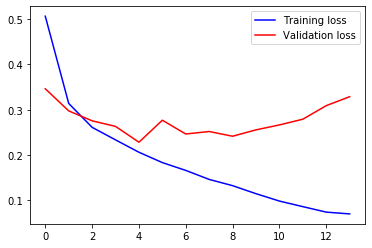

In [27]:
epochs_plot = range(len(train_history.history['loss']))
plt.figure()
plt.plot(epochs_plot, train_history.history['loss'], 'b', label='Training loss' )
plt.plot(epochs_plot, train_history.history['val_loss'], 'r', label='Validation loss')
plt.legend()
plt.show()

In [28]:
print(train_history.history['val_loss'])

[0.3463525353272756, 0.2974950246810913, 0.27559940445423126, 0.26323749419053394, 0.228315143207709, 0.276888716340065, 0.24645405457417172, 0.2519674802025159, 0.24152891339858373, 0.25561834490299223, 0.2664909458557765, 0.2791452117661635, 0.3091056975126266, 0.3288229314684868]


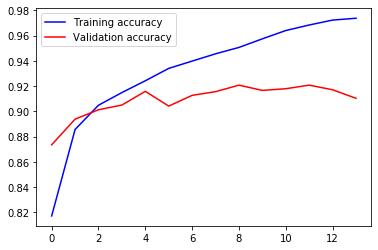

In [29]:
plt.figure()
plt.plot(epochs_plot, train_history.history['accuracy'], 'b', label='Training accuracy' )
plt.plot(epochs_plot, train_history.history['val_accuracy'], 'r', label='Validation accuracy')
plt.legend()
plt.show()

From the last plot it is clear that the algorithm stopped at the 8th epoch, since accuracy on the validation set decreased for the next epochs. With this the CNN has achieved a 91% of accuracy. This probably can be improved by implementing Dropout layers.

In [30]:
#Saving the model and the weights
model.save_weights('weights_fashion_modelc332_mp2_c364_mp2_c3128_f_d128_d10.h5')
model.save('simple_fashion_model_c332_mp2_c364_mp2_c3128_f_d128_d10.h5py')


## CNN with Dropout layers

In [31]:
batch_drop = 64
epochs_drop = 20

model_drop = Sequential()
model_drop.add(Conv2D(32,kernel_size=3, activation='relu', input_shape = (28,28,1), padding='same'))
model_drop.add(MaxPool2D(2))
model_drop.add(Dropout(0.25))
model_drop.add(Conv2D(64, kernel_size=3, activation='relu', padding = 'same'))
model_drop.add(MaxPool2D(2))
model_drop.add(Dropout(0.25))
model_drop.add(Conv2D(128, kernel_size = 3, activation='relu', padding='same'))
model_drop.add(MaxPool2D(2))
model_drop.add(Dropout(0.4))
model_drop.add(Flatten())
model_drop.add(Dense(128, activation = 'relu'))
model_drop.add(Dropout(0.3))
model_drop.add(Dense(num_classes, activation = 'softmax'))
model_drop.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 7, 7, 128)        

In [32]:
model_drop.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [33]:
train_drop_history = model_drop.fit(X_train, y_train, batch_size=batch_size, epochs=epochs_drop,validation_data = (X_val, y_val), verbose=1,callbacks=[monitor_val_acc])

Train on 48000 samples, validate on 12000 samples
Epoch 1/20
48000/48000 [==============================] - 7s 139us/step - loss: 0.6632 - accuracy: 0.7552 - val_loss: 0.3817 - val_accuracy: 0.8662
Epoch 2/20
48000/48000 [==============================] - 6s 130us/step - loss: 0.4130 - accuracy: 0.8499 - val_loss: 0.3207 - val_accuracy: 0.8832
Epoch 3/20
48000/48000 [==============================] - 6s 134us/step - loss: 0.3629 - accuracy: 0.8661 - val_loss: 0.2881 - val_accuracy: 0.8970
Epoch 4/20
48000/48000 [==============================] - 7s 138us/step - loss: 0.3311 - accuracy: 0.8773 - val_loss: 0.2742 - val_accuracy: 0.8988
Epoch 5/20
48000/48000 [==============================] - 6s 132us/step - loss: 0.3103 - accuracy: 0.8880 - val_loss: 0.2741 - val_accuracy: 0.9008
Epoch 6/20
48000/48000 [==============================] - 6s 132us/step - loss: 0.2940 - accuracy: 0.8916 - val_loss: 0.2447 - val_accuracy: 0.9082
Epoch 7/20
48000/48000 [==============================] - 6s 1

In [34]:
test_eval_drop = model_drop.evaluate(X_test_scaled,y_test_ohe, verbose =1)
print(test_eval[0])
print(test_eval[1])

10000/10000 [==============================] - 1s 62us/step
0.3429361968480051
0.9068999886512756


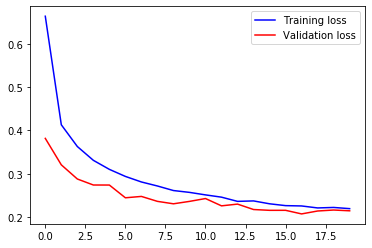

In [36]:
epochs_plot_drop = range(len(train_drop_history.history['loss']))
plt.figure()
plt.plot(epochs_plot_drop, train_drop_history.history['loss'], 'b', label='Training loss' )
plt.plot(epochs_plot_drop, train_drop_history.history['val_loss'], 'r', label='Validation loss')
plt.legend()
plt.show()

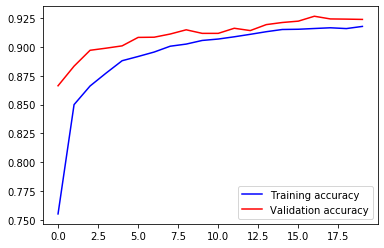

In [37]:
plt.figure()
plt.plot(epochs_plot_drop, train_drop_history.history['accuracy'], 'b', label='Training accuracy' )
plt.plot(epochs_plot_drop, train_drop_history.history['val_accuracy'], 'r', label='Validation accuracy')
plt.legend()
plt.show()

In [38]:
predicted_drop = model_drop.evaluate(X_test_scaled, y_test_ohe, verbose=1)
print(test_eval[0])
print(test_eval[1])

10000/10000 [==============================] - 1s 62us/step
0.3429361968480051
0.9068999886512756


In [39]:
#Saving fashion model with dropout layers
model_drop.save_weights("fashion_model_with_dropoutlayers_weights.h5")
model_drop.save("fashion_model_with_dropout.h5py")